In [1]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition

# mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_tracking_uri(uri="http://mlflow:5000")

In [8]:
# Load the Iris dataset
X, y = datasets.load_iris(return_X_y=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model hyperparameters
params = {"solver": "lbfgs", "max_iter": 1000, "multi_class": "auto", "random_state": 8888}

# Train the model
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)


# Calculate accuracy as a target loss metric
accuracy = accuracy_score(y_test, y_pred)

In [10]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [7]:
len(X), len(y)

(150, 150)

In [11]:
mlflow.set_experiment("test")

<Experiment: artifact_location='s3://mlflow-artifacts/1', creation_time=1710714592665, experiment_id='1', last_update_time=1710714592665, lifecycle_stage='active', name='test', tags={}>

In [21]:
import os
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'
os.environ['AWS_ACCESS_KEY_ID'] = '74cvoBegkXBHT7jJ'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'RnCFp2DyrinPOMF8jtollC5fqvBiHcUY'

In [13]:
artifact_uri = "s3://mlflow-artifacts"

In [12]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="iris_model",
        #signature=signature,
        input_example=X_train,
        registered_model_name="tracking-test",
    )
    
    model_uri = model_info.model_uri
    
    result = mlflow.evaluate(
        model_uri,
        X_test,
        targets=y_test,
        model_type="classifier",
        evaluators=["default"],
    )

Registered model 'tracking-test' already exists. Creating a new version of this model...
2024/03/23 23:01:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-test, version 2
Created version '2' of model 'tracking-test'.


2024/03/23 23:01:57 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/23 23:01:57 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
/usr/local/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
2024/03/23 23:01:57 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 3
/usr/local/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
2024/03/23 23:01:57 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/23 23:01:59 WARNING mlflo

<Figure size 1050x700 with 0 Axes>

In [13]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

In [62]:
predictions = loaded_model.predict(X_test)

iris_feature_names = datasets.load_iris().feature_names

# Convert X_test validation feature data to a Pandas DataFrame
result = pd.DataFrame(X_test, columns=iris_feature_names)

# Add the actual classes to the DataFrame
result["actual_class"] = y_test

# Add the model predictions to the DataFrame
result["predicted_class"] = predictions

# TEST
# result.at[3, "predicted_class"] = 13

result[:4]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),actual_class,predicted_class
0,6.1,2.8,4.7,1.2,1,1
1,5.7,3.8,1.7,0.3,0,0
2,7.7,2.6,6.9,2.3,2,2
3,6.0,2.9,4.5,1.5,1,1


In [24]:
result["sepal length (cm)"] / result["sepal width (cm)"]

0     2.178571
1     1.500000
2     2.961538
3     2.068966
4     2.428571
5     1.588235
6     1.931034
7     2.225806
8     2.818182
9     2.148148
10    2.031250
11    1.600000
12    1.571429
13    1.580645
14    1.342105
15    1.909091
16    2.166667
17    2.240000
18    2.035714
19    2.285714
20    1.468750
21    2.033333
22    1.470588
23    2.285714
24    2.078947
25    2.233333
26    2.680000
27    2.125000
28    1.600000
29    1.548387
dtype: float64

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
errors_filter = result["actual_class"] != result["predicted_class"]
errors_filter
errors = result[errors_filter]
errors

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),actual_class,predicted_class
3,6.0,2.9,4.5,1.5,1,13


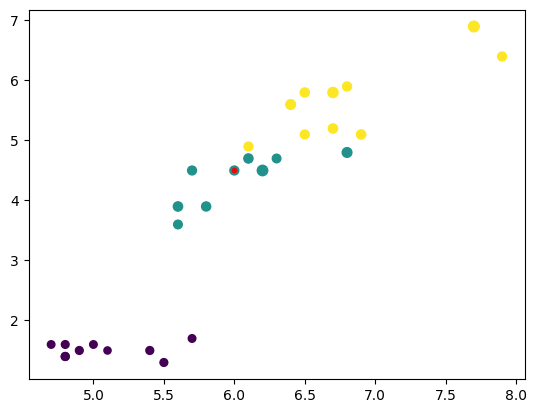

In [56]:
plt.scatter(
    x=result[["sepal length (cm)"]],
    y=result[["petal length (cm)"]],
    s=(result["sepal length (cm)"] / result["sepal width (cm)"]) * 20,
    c=result["actual_class"],
)
plt.scatter(
    x=errors[["sepal length (cm)"]],
    y=errors[["petal length (cm)"]],
    s=10,
    c="red"
)
plt.show()

<Axes: xlabel='sepal length (cm)', ylabel='petal length (cm)'>

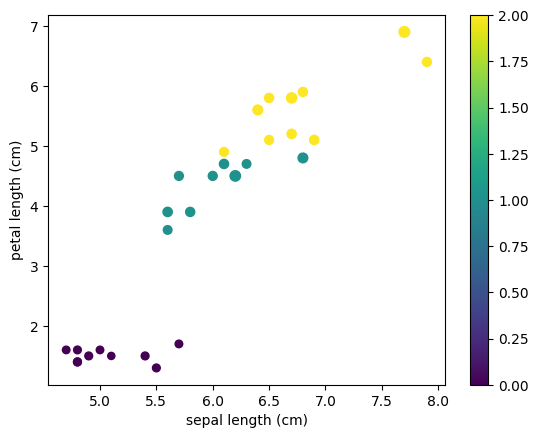

In [38]:
result.plot.scatter(
    x="sepal length (cm)", 
    y="petal length (cm)", 
    s=(result["sepal length (cm)"] / result["sepal width (cm)"]) * 20,
    c=result["actual_class"],
    colormap='viridis'
)

In [ ]:

plt.scatter(
    x=result[["sepal length (cm)"]],
    y=result[["petal length (cm)"]],
    s=(result["sepal length (cm)"] / result["sepal width (cm)"]) * 20,
    c=result["actual_class"],
)

---

# Make predictions

In [64]:
logged_model = 'runs:/16824196e24d4c60b79a9ca8058ec7d1/iris_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
result = pd.DataFrame(X, columns=iris_feature_names)
result["actual_class"] = y
result["predicted_class"] = loaded_model.predict(pd.DataFrame(X))

result

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),actual_class,predicted_class
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2
146,6.3,2.5,5.0,1.9,2,2
147,6.5,3.0,5.2,2.0,2,2
148,6.2,3.4,5.4,2.3,2,2


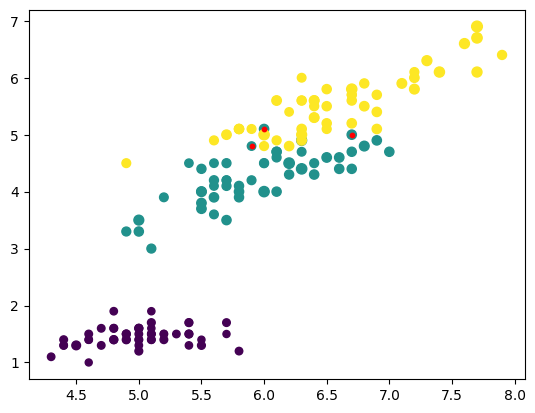

In [66]:
plt.scatter(
    x=result[["sepal length (cm)"]],
    y=result[["petal length (cm)"]],
    s=(result["sepal length (cm)"] / result["sepal width (cm)"]) * 20,
    c=result["actual_class"],
)
errors = result[result["actual_class"] != result["predicted_class"]]
plt.scatter(
    x=errors[["sepal length (cm)"]],
    y=errors[["petal length (cm)"]],
    s=10,
    c="red"
)
plt.show()